In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import datetime

from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler
from sklearn.preprocessing import OneHotEncoder

from matplotlib import pyplot as plt

### Preparing data

In [2]:
# Dowloading data
df = pd.read_csv('train.zip', compression='zip', header=0, sep=',', quotechar='"')

In [3]:
df[:2]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663


- id - a unique identifier for each trip
- vendor_id - a code indicating the provider associated with the trip record
- pickup_datetime - date and time when the meter was engaged
- dropoff_datetime - date and time when the meter was disengaged
- passenger_count - the number of passengers in the vehicle (driver entered value)
- pickup_longitude - the longitude where the meter was engaged
- pickup_latitude - the latitude where the meter was engaged
- dropoff_longitude - the longitude where the meter was disengaged
- dropoff_latitude - the latitude where the meter was disengaged
- store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
- trip_duration - duration of the trip in seconds

In [4]:
# Drop the 'dropoff_datetime' column from the DataFrame.
df = df.drop('dropoff_datetime', axis=1)

# Convert the 'pickup_datetime' column to datetime objects.
df.pickup_datetime = pd.to_datetime(df.pickup_datetime)

# Sort the DataFrame by the 'pickup_datetime' column.
df = df.sort_values(by='pickup_datetime')

# Display the first 5 rows of the DataFrame.
df.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
96469,id0190469,2,2016-01-01 00:00:17,5,-73.981743,40.719158,-73.938828,40.829182,N,849
223872,id1665586,1,2016-01-01 00:00:53,1,-73.985085,40.747166,-73.958038,40.717491,N,1294
713067,id1210365,2,2016-01-01 00:01:01,5,-73.965279,40.801041,-73.947479,40.815170,N,408
652463,id3888279,1,2016-01-01 00:01:14,1,-73.982292,40.751331,-73.991341,40.750340,N,280
722901,id0924227,1,2016-01-01 00:01:20,1,-73.970108,40.759800,-73.989357,40.742989,N,736


In [5]:
# Split the DataFrame into training and testing sets.
# Take the first 1 million rows for training.
df_train = df[:10**6] 

# Take the remaining rows for testing.
df_test = df[10**6:] 

<Axes: >

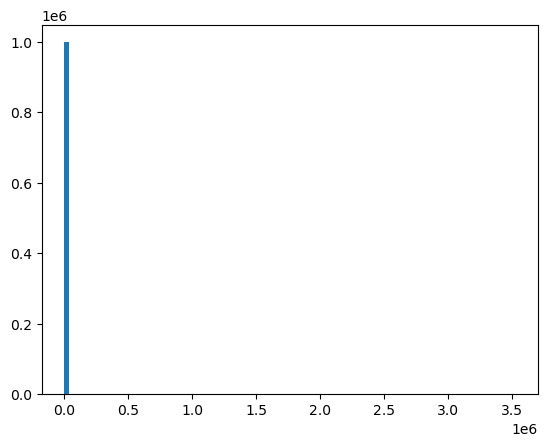

In [6]:
# Plot a histogram of the 'trip_duration' column in the training set.
df_train.trip_duration.hist(bins=100, grid=False,)

<Axes: >

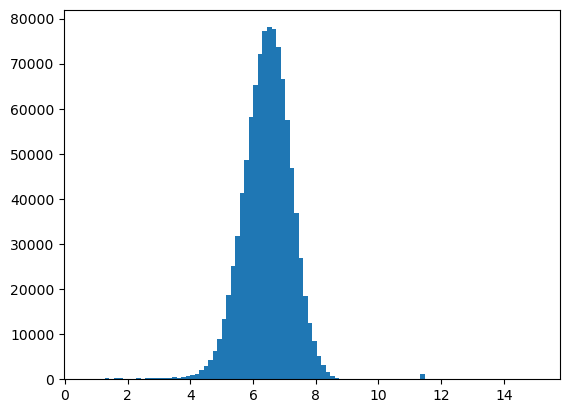

In [7]:
# Plot a histogram of the log-transformed 'trip_duration' in the training set.
np.log1p(df_train.trip_duration).hist(bins=100, grid = False)

In [8]:
# Create a new column 'log_trip_duration' in both training and testing sets, 
# containing the log-transformed 'trip_duration' values.
df_train['log_trip_duration'] = np.log1p(df_train.trip_duration)
df_test['log_trip_duration'] = np.log1p(df_test.trip_duration)

C:\Users\Yuriy Podmogaev\AppData\Local\Temp\ipykernel_9652\2574982898.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['log_trip_duration'] = np.log1p(df_train.trip_duration)
C:\Users\Yuriy Podmogaev\AppData\Local\Temp\ipykernel_9652\2574982898.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['log_trip_duration'] = np.log1p(df_test.trip_duration)


In [9]:
# Convert the 'pickup_datetime' column to datetime objects.
df.pickup_datetime = pd.to_datetime(df.pickup_datetime)

In [10]:
def create_features(data_frame):
    """
    Extracts 'day' and 'hour' features from the 'pickup_datetime' column.

    Args:
        data_frame: A Pandas DataFrame containing the data.

    Returns:
        A tuple containing the feature matrix (X) and the target variable (y).
    """
    # Extract 'day' and 'hour' features using lambda functions.
    X = pd.concat([
        data_frame.pickup_datetime.apply(lambda x: x.timetuple().tm_yday),
        data_frame.pickup_datetime.apply(lambda x: x.hour),
        ], axis= 1, keys=['day', 'hour',]
    )

    # Return the feature matrix (X) and the log-transformed trip duration (y).
    return X, data_frame.log_trip_duration

In [11]:
# Call the 'create_features' function to extract features from the training set.
X_train, y_train = create_features(df_train)

# Call the 'create_features' function to extract features from the testing set.
X_test, y_test = create_features(df_test)

In [12]:
# Create a ColumnTransformer object to apply one-hot encoding to the specified feature.
ohe = ColumnTransformer([("One hot", OneHotEncoder(), [1])], remainder="passthrough") 

In [13]:
# Call the 'create_features' function to extract features from the training set.
X_train, y_train = create_features(df_train)

# Call the 'create_features' function to extract features from the testing set.
X_test, y_test = create_features(df_test)

### Let's use the LinearRegression class and train the model.

In [14]:
# Create a LinearRegression object.
lin_reg = LinearRegression() 

# Fit the linear regression model to the training data.
lin_reg.fit(X_train, y_train)

# Calculate the mean squared error between the model's predictions on the testing data and the actual values.
mean_squared_error(lin_reg.predict(X_test), y_test)

0.6619213022706769

### Let's use the Ridge class and train the model.

In [15]:
# Create a Ridge regression model with a regularization strength of 1000
ridge = Ridge(alpha=1000).fit(X_train, y_train)

# Predict the target values for the test set using the trained model
predictions = ridge.predict(X_test)

# Calculate the mean squared error between the predicted and actual values
mean_squared_error(predictions, y_test)

0.6619213120943772

In [16]:
# Define the parameter grid for grid search
param_grid = {'alpha': np.linspace(1, 501, 10)}

# Create a GridSearchCV object with the model, parameter grid, and cross-validation folds
grid_searcher = GridSearchCV(ridge,
                            param_grid=param_grid,
                            cv=3)

# Fit the grid search to the training data
grid_searcher.fit(X_train, y_train)

# Get the predictions on the test data using the best model found by grid search
predictions = grid_searcher.predict(X_test)

# Calculate the mean squared error between the predictions and the actual test values
mean_squared_error(predictions, y_test)

0.6619213071922814

In [17]:
grid_searcher.best_params_

{'alpha': 501.0}

In [18]:
def create_features(data_frame):
    """
    Creates features from the given DataFrame.

    Args:
        data_frame: The DataFrame containing the data.

    Returns:
        A tuple containing the feature matrix (X) and the target variable (y).
    """
    # Extract day of year from pickup datetime
    X = pd.concat([
        data_frame.pickup_datetime.apply(lambda x: x.timetuple().tm_yday),  # Day of year
        
        # Extract hour from pickup datetime
        data_frame.pickup_datetime.apply(lambda x: x.hour),  # Hour of day
        
        # Create a feature indicating if the date is in a specific range
        data_frame.pickup_datetime.dt.date.apply(lambda x: 1 if any(str(x) == item for item in ['2016-01-23', '2016-01-24']) else 0),  # In specific date range
        
        # Extract weekday from pickup datetime
        data_frame.pickup_datetime.dt.weekday,  # Day of week
        ], axis= 1, keys=['day', 'hour', 'in', 'week']
    )
    
    # Extract the log trip duration as the target variable
    y = data_frame.log_trip_duration

    return X, y

In [19]:
# Create features for the training set
X_train, y_train = create_features(df_train)

# Create features for the testing set
X_test, y_test = create_features(df_test)

In [20]:
# Create a ColumnTransformer object to perform one-hot encoding on specified columns
ohe = ColumnTransformer([
    # Apply OneHotEncoder to the columns 'hour', 'in', and 'week'
    ("One hot", OneHotEncoder(), ['hour','in','week'])
], 
    # Pass through the remaining columns without transformation
    remainder="passthrough")

# Fit the ColumnTransformer to the training data to learn the unique values for encoding
X_train = ohe.fit_transform(X_train)

# Transform the test data using the learned encoding from the training data
X_test = ohe.transform(X_test)

In [21]:
# Create a MaxAbsScaler object
scaler = MaxAbsScaler()

# Fit the scaler to the training data
# This calculates the maximum absolute value for each feature in the training data
scaler.fit(X_train)

# Transform the training data using the fitted scaler
# This scales the training data by dividing each feature by its maximum absolute value
X_train = scaler.transform(X_train)

# Transform the test data using the same scaler
# This ensures that both the training and test data are scaled using the same scaling parameters
X_test = scaler.transform(X_test)

In [22]:
# Create Lasso Regression model
model = Lasso(alpha=2.65e-05)

# Fit the model
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

# Calculate MSE
mse = mean_squared_error(y_test, predictions)

In [24]:
# Find number of selected features
selected_features = np.sum(abs(model.coef_) > 1e-6) 

print(f"MSE: {mse}")
print(f"Number of selected features: {selected_features}")

MSE: 0.6504014165969954
Number of selected features: 31
